In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab style plot
import seaborn as sns # affichage, on peut utiliser d'autres librairies
import statsmodels.api as sm # modèle stat contenant le modèle ARIMA
from pylab import *
from scipy import stats
from scipy.stats import normaltest

color = sns.color_palette()
sns.set_style('darkgrid')


In [2]:
from models import *

README.md                        sp-explanatory-train.csv
S&P_500_closing_behaviour.ipynb  sp-explanatory-valid.csv
sp-explanatory-test.csv          sp-response-train.csv


## Utils

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import keras
from keras.layers import *

from keras.models import Sequential

Using TensorFlow backend.


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## S&P 500 closing behaviour 

In [15]:
rcParams['figure.figsize'] = 24, 13

In [0]:
from zipfile import *
zip = ZipFile('Hackathon_Sujet_1_data.zip')
zip.extractall() 

In [0]:
cd Hackathon_Sujet_1_data

/content/Hackathon_Sujet_1_data


In [16]:
ls

README.md                        sp-explanatory-train.csv
S&P_500_closing_behaviour.ipynb  sp-explanatory-valid.csv
sp-explanatory-test.csv          sp-response-train.csv


## Data preparation and visualisation

In [17]:
sp_train = pd.read_csv("sp-explanatory-train.csv")
col_names = sp_train.columns
sp_y_train = pd.read_csv("sp-response-train.csv")
sp_test = pd.read_csv("sp-explanatory-test.csv", names =col_names)
sp_val= pd.read_csv("sp-explanatory-valid.csv", names =col_names )
sp_test.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,...,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240
0,140150625,123078282,100,100.0456,100.0182,100.0638,100.0729,100.0638,100.0456,100.0547,...,100.5831,100.6105,100.5923,100.5831,100.5923,100.5649,100.5376,100.5376,100.5558,100.5649
1,131474897,77664097,100,99.9890,99.9781,99.9890,99.9890,100.0000,100.0000,100.0000,...,100.5923,100.5704,100.5375,100.5155,100.4936,100.5155,100.5265,100.5265,100.5375,100.5265
2,70777365,56312513,100,99.9872,99.9745,99.9745,99.9872,99.9745,99.9617,99.9489,...,100.3575,100.3703,100.3320,100.3320,100.3192,100.3192,100.3192,100.3192,100.3320,100.3192
3,93488804,56667536,100,100.0000,100.0000,100.0000,100.0134,100.0134,99.9866,100.0000,...,99.8932,99.8665,99.8932,99.8932,99.9332,99.9733,99.9466,99.9733,99.9866,100.0000
4,197333777,122747762,100,99.9829,99.9914,99.9914,99.9829,99.9829,99.9914,99.9829,...,99.8371,99.8800,99.8800,99.8714,99.9057,99.9314,99.8971,99.8885,99.8885,99.8885


In [18]:
sp_train.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,...,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240
0,131500151,73564094,100,100.0000,99.9877,100.0000,99.9877,99.9877,99.9754,100.0000,...,100.1476,100.1353,100.1353,100.1107,100.0984,100.0738,100.0615,100.0369,100.0246,99.9877
1,49061693,68383750,100,99.9900,99.9801,100.0000,99.9602,100.0000,100.0000,100.0000,...,99.0936,99.0837,99.0637,99.0538,99.0637,99.1434,99.1733,99.2131,99.2131,99.3028
2,79306648,96243823,100,100.0244,99.9878,99.9634,99.9512,99.9634,100.0000,100.0000,...,100.1099,100.0855,100.1099,100.0977,100.0977,100.0855,100.0733,100.0977,100.1099,100.1465
3,190750562,93258399,100,100.0000,99.9896,99.9896,99.9896,99.9896,99.9791,99.9896,...,99.7705,99.7393,99.7288,99.7288,99.7184,99.7288,99.7184,99.7080,99.7184,99.7184
4,209460450,142983394,100,100.0000,99.9909,99.9909,99.9818,99.9818,99.9909,99.9909,...,101.0291,101.0200,101.0291,101.0018,101.0200,101.0109,100.9927,101.0109,101.0747,101.0565


In [19]:
df_train = sp_train
df_train["Target"]= sp_y_train;df_train.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,...,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target
0,131500151,73564094,100,100.0000,99.9877,100.0000,99.9877,99.9877,99.9754,100.0000,...,100.1353,100.1353,100.1107,100.0984,100.0738,100.0615,100.0369,100.0246,99.9877,0
1,49061693,68383750,100,99.9900,99.9801,100.0000,99.9602,100.0000,100.0000,100.0000,...,99.0837,99.0637,99.0538,99.0637,99.1434,99.1733,99.2131,99.2131,99.3028,0
2,79306648,96243823,100,100.0244,99.9878,99.9634,99.9512,99.9634,100.0000,100.0000,...,100.0855,100.1099,100.0977,100.0977,100.0855,100.0733,100.0977,100.1099,100.1465,0
3,190750562,93258399,100,100.0000,99.9896,99.9896,99.9896,99.9896,99.9791,99.9896,...,99.7393,99.7288,99.7288,99.7184,99.7288,99.7184,99.7080,99.7184,99.7184,1
4,209460450,142983394,100,100.0000,99.9909,99.9909,99.9818,99.9818,99.9909,99.9909,...,101.0200,101.0291,101.0018,101.0200,101.0109,100.9927,101.0109,101.0747,101.0565,0


In [20]:
df_train.describe()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,...,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target
count,9.140000e+02,9.140000e+02,914.0,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,...,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,1.359660e+08,1.110302e+08,100.0,100.000403,100.000170,100.001375,100.002471,100.001270,100.001555,100.001279,...,99.992992,99.992773,99.992995,99.990732,99.990679,99.991366,99.991470,99.991520,99.990628,0.439825
std,7.325568e+07,5.018243e+07,0.0,0.018365,0.024977,0.029144,0.033583,0.037661,0.040216,0.042899,...,0.408236,0.409609,0.408977,0.411103,0.409182,0.409679,0.408465,0.413392,0.412469,0.496638
min,1.364043e+07,2.732368e+07,100.0,99.855800,99.793800,99.780000,99.738800,99.725000,99.793000,99.752500,...,98.338200,98.286300,98.381500,98.346900,98.468100,98.433400,98.520000,98.528600,98.502200,0.000000
25%,8.281084e+07,7.600727e+07,100.0,99.989625,99.988000,99.988000,99.987625,99.985200,99.985200,99.981100,...,99.778175,99.784950,99.777700,99.776500,99.773075,99.780225,99.781450,99.772450,99.778575,0.000000
50%,1.209911e+08,1.008863e+08,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.009650,100.000000,100.009600,100.009850,100.010050,100.012100,100.009100,100.013050,100.010950,0.000000
75%,1.755882e+08,1.357449e+08,100.0,100.011700,100.012000,100.013200,100.017200,100.019400,100.019550,100.021200,...,100.240450,100.236200,100.232975,100.239050,100.237825,100.234350,100.232400,100.233475,100.232300,1.000000
max,5.358532e+08,4.073586e+08,100.0,100.075400,100.102000,100.128000,100.159700,100.164600,100.196600,100.234500,...,102.059500,102.083300,102.166700,102.119000,102.047600,102.047600,102.119000,102.178600,102.190500,1.000000


Text(0, 0.5, 'le cours du SP500 ')

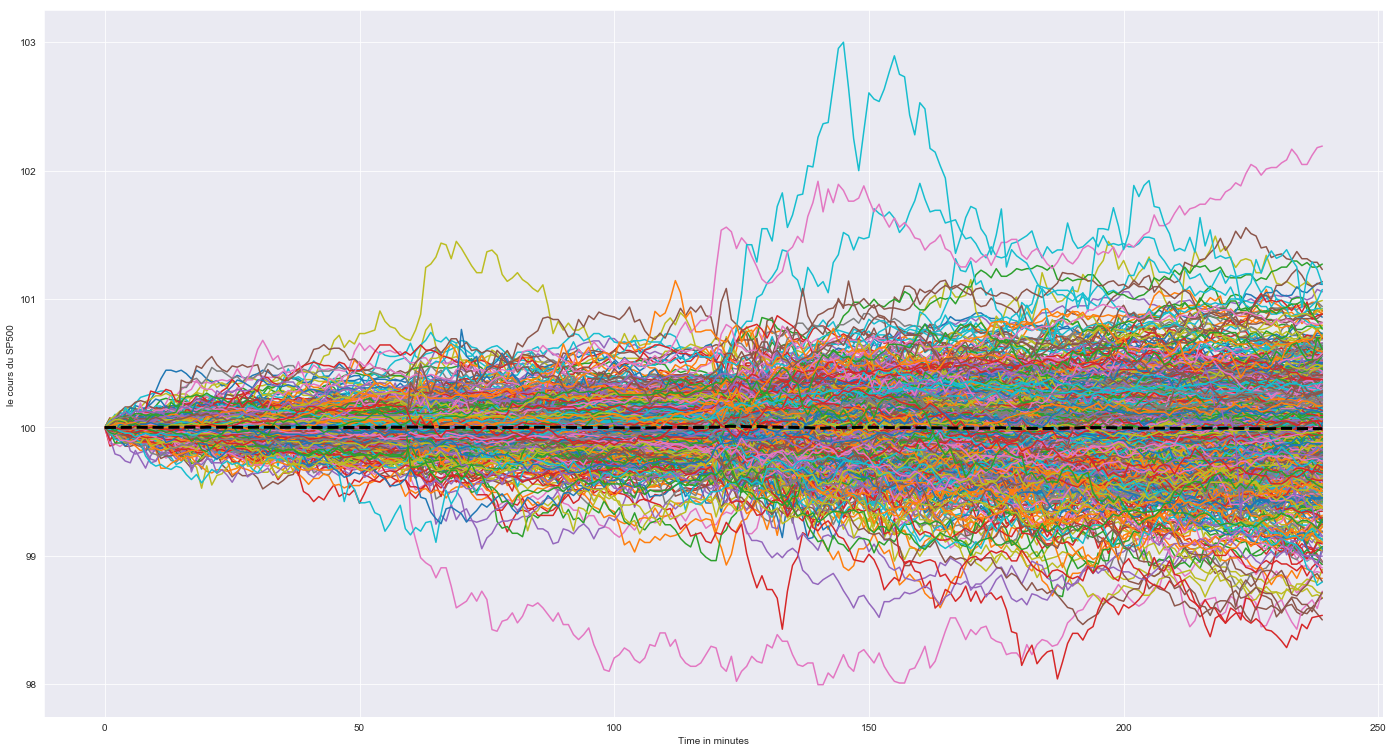

In [21]:
#plot(sp_train.values.T[2:-1,:].mean(axis = 1), ls = "--", lw= 20)
plot(sp_train.values.T[2:-1,:]);
plot(sp_train.values.T[2:-1,:].mean(axis = 1),color = "black", ls = "--", lw= 3)
xlabel("Time in minutes")
ylabel("le cours du SP500 ")

### Data normalisation

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(sp_train)

In [27]:
x = x_scaled.reshape(-1,243,1); x[2,:2]

array([[-0.77387063],
       [-0.29481413]])

In [31]:
df_processed = pd.DataFrame(x_scaled, columns=df_train.columns); 
df_processed["exchange"] = df_train["exchange"] # categorical
df_processed["sector"]= df_train["sector"]  # categorical
df_processed["Target"] = sp_y_train; df_processed.head(3) 


,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,...,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target
count,9.140000e+02,9.140000e+02,914.0,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,...,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,1.359660e+08,1.110302e+08,100.0,100.000403,100.000170,100.001375,100.002471,100.001270,100.001555,100.001279,...,99.992992,99.992773,99.992995,99.990732,99.990679,99.991366,99.991470,99.991520,99.990628,0.439825
std,7.325568e+07,5.018243e+07,0.0,0.018365,0.024977,0.029144,0.033583,0.037661,0.040216,0.042899,...,0.408236,0.409609,0.408977,0.411103,0.409182,0.409679,0.408465,0.413392,0.412469,0.496638
min,1.364043e+07,2.732368e+07,100.0,99.855800,99.793800,99.780000,99.738800,99.725000,99.793000,99.752500,...,98.338200,98.286300,98.381500,98.346900,98.468100,98.433400,98.520000,98.528600,98.502200,0.000000
25%,8.281084e+07,7.600727e+07,100.0,99.989625,99.988000,99.988000,99.987625,99.985200,99.985200,99.981100,...,99.778175,99.784950,99.777700,99.776500,99.773075,99.780225,99.781450,99.772450,99.778575,0.000000
50%,1.209911e+08,1.008863e+08,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.009650,100.000000,100.009600,100.009850,100.010050,100.012100,100.009100,100.013050,100.010950,0.000000
75%,1.755882e+08,1.357449e+08,100.0,100.011700,100.012000,100.013200,100.017200,100.019400,100.019550,100.021200,...,100.240450,100.236200,100.232975,100.239050,100.237825,100.234350,100.232400,100.233475,100.232300,1.000000
max,5.358532e+08,4.073586e+08,100.0,100.075400,100.102000,100.128000,100.159700,100.164600,100.196600,100.234500,...,102.059500,102.083300,102.166700,102.119000,102.047600,102.047600,102.119000,102.178600,102.190500,1.000000


In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(x_scaled, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)


In [0]:
model = build_MLP( input_shape = (243,), activation = 'relu', units = [200,100],
                  momentum=0.1, epsilon=1e-05, dropout_rate = 0.3)

In [0]:
hist = model.fit(sp_train,sp_y_train,batch_size=30, epochs=10)

Epoch 1/10
914/914 [==============================] - 0s 213us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 2/10
914/914 [==============================] - 0s 207us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 3/10
914/914 [==============================] - 0s 204us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 4/10
914/914 [==============================] - 0s 193us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 5/10
914/914 [==============================] - 0s 197us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 6/10
914/914 [==============================] - 0s 202us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 7/10
914/914 [==============================] - 0s 209us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 8/10
914/914 [==============================] - 0s 205us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 9/10
914/914 [==============================] - 0s 197us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 10/10
914/914 [==============================] - 0s 199us/step - loss: 8.589

## Fastai API for tabular data

In [0]:
from fastai.tabular import *

In [0]:
df = df_train

In [0]:
dep_var = 'Target'
cat_names = []
cont_names = sp_train.columns
procs = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(df.iloc[600:914].copy(), cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(600,914)))
                           .label_from_df(cols=dep_var)
                           #.add_test(test)
                           .databunch())

In [0]:
data.show_batch(rows=10)

openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,closeMin039,closeMin040,closeMin041,closeMin042,closeMin043,closeMin044,closeMin045,closeMin046,closeMin047,closeMin048,closeMin049,closeMin050,closeMin051,closeMin052,closeMin053,closeMin054,closeMin055,closeMin056,closeMin057,closeMin058,closeMin059,closeMin060,closeMin061,closeMin062,closeMin063,closeMin064,closeMin065,closeMin066,closeMin067,closeMin068,closeMin069,closeMin070,closeMin071,closeMin072,closeMin073,closeMin074,closeMin075,closeMin076,closeMin077,closeMin078,closeMin079,closeMin080,closeMin081,closeMin082,closeMin083,closeMin084,closeMin085,closeMin086,closeMin087,closeMin088,closeMin089,closeMin090,closeMin091,closeMin092,closeMin093,closeMin094,closeMin095,closeMin096,closeMin097,closeMin098,closeMin099,closeMin100,closeMin101,closeMin102,closeMin103,closeMin104,closeMin105,closeMin106,closeMin107,closeMin108,closeMin109,closeMin110,closeMin111,closeMin112,closeMin113,closeMin114,closeMin115,closeMin116,closeMin117,closeMin118,closeMin119,closeMin120,closeMin121,closeMin122,closeMin123,closeMin124,closeMin125,closeMin126,closeMin127,closeMin128,closeMin129,closeMin130,closeMin131,closeMin132,closeMin133,closeMin134,closeMin135,closeMin136,closeMin137,closeMin138,closeMin139,closeMin140,closeMin141,closeMin142,closeMin143,closeMin144,closeMin145,closeMin146,closeMin147,closeMin148,closeMin149,closeMin150,closeMin151,closeMin152,closeMin153,closeMin154,closeMin155,closeMin156,closeMin157,closeMin158,closeMin159,closeMin160,closeMin161,closeMin162,closeMin163,closeMin164,closeMin165,closeMin166,closeMin167,closeMin168,closeMin169,closeMin170,closeMin171,closeMin172,closeMin173,closeMin174,closeMin175,closeMin176,closeMin177,closeMin178,closeMin179,closeMin180,closeMin181,closeMin182,closeMin183,closeMin184,closeMin185,closeMin186,closeMin187,closeMin188,closeMin189,closeMin190,closeMin191,closeMin192,closeMin193,closeMin194,closeMin195,closeMin196,closeMin197,closeMin198,closeMin199,closeMin200,closeMin201,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target,target
-0.4161,-1.1274,0.0000,1.2545,1.4783,1.6613,1.4168,0.6300,0.8655,0.5617,0.2418,0.2118,0.6362,0.6115,0.5677,0.5278,0.9116,0.5016,0.6748,0.8217,0.7815,0.6162,0.7580,0.7509,1.0585,0.8932,0.7278,1.0022,0.9869,0.9946,1.1212,1.2068,1.1773,1.1605,1.0250,1.1517,1.2538,0.9814,0.9571,0.9542,0.9499,0.8172,0.8009,0.7900,0.7903,0.6624,0.4149,0.5186,0.7279,0.6344,0.6290,0.9227,0.9039,0.9121,0.8036,0.8029,0.7793,0.8821,1.0758,1.0662,1.0694,1.0703,0.8879,0.9386,1.0503,0.9971,1.0471,1.0294,1.0322,1.0364,0.9619,0.9152,0.9157,0.9248,1.0718,0.9241,1.0674,0.8209,0.8070,0.9343,0.8804,0.9535,0.8772,0.8658,1.1441,1.2736,1.2051,1.3459,1.2625,1.1305,1.1327,1.1472,1.3386,1.3339,1.5248,1.6625,1.7871,2.0491,2.0220,2.2273,2.1569,2.0784,2.0802,2.0237,2.0022,2.0686,1.9859,1.9406,1.9470,1.9650,1.9560,1.8915,1.8818,1.8025,1.7310,1.6417,1.5623,1.5699,1.7046,1.5655,1.5714,1.6189,1.5228,1.5201,1.6656,1.4263,1.6611,1.5134,1.2167,0.9877,1.0612,1.0995,1.0611,0.7987,0.9549,0.8440,1.0994,0.9919,0.8444,0.9429,0.9322,0.8394,0.9972,0.9947,1.0406,1.2011,1.1985,1.3302,1.2787,1.1765,1.0852,1.1155,0.9941,1.0957

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [0]:
learn.fit(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.479961,0.526335,0.799363,00:00
1,0.311117,0.081639,0.977707,00:00
2,0.223599,0.176661,0.936306,00:00
3,0.184586,0.052629,0.971338,00:00
4,0.143433,0.073473,0.984076,00:00
5,0.113916,0.078807,0.980892,00:00
6,0.094956,0.114374,0.955414,00:00
7,0.077320,0.062629,0.977707,00:00
8,0.065385,0.035062,0.993631,00:00
9,0.055308,0.002578,1.000000,00:00


## Convolutionnal network based model

In [0]:
from keras.layers import *
import keras

In [37]:
cnn = build_CNN(input_shape = (243,1), filters = [30,30], kernels = [4,4])
cnn.summary()
hist = cnn.fit(x,sp_y_train,batch_size=40, epochs=200)


Epoch 193/200
914/914 [==============================] - 0s 204us/step - loss: 0.2472 - accuracy: 0.9048 - val_loss: 0.2544 - val_accuracy: 0.9028
Epoch 194/200
914/914 [==============================] - 0s 207us/step - loss: 0.2007 - accuracy: 0.9223 - val_loss: 0.2532 - val_accuracy: 0.9135
Epoch 195/200
914/914 [==============================] - 0s 223us/step - loss: 0.2335 - accuracy: 0.9037 - val_loss: 0.2483 - val_accuracy: 0.9123
Epoch 196/200
914/914 [==============================] - 0s 204us/step - loss: 0.2144 - accuracy: 0.9158 - val_loss: 0.2372 - val_accuracy: 0.9120
Epoch 197/200
914/914 [==============================] - 0s 214us/step - loss: 0.2330 - accuracy: 0.9037 - val_loss: 0.2361 - val_accuracy: 0.9126
Epoch 198/200
914/914 [==============================] - 0s 206us/step - loss: 0.2585 - accuracy: 0.8764 - val_loss: 0.2339 - val_accuracy: 0.9011
Epoch 199/200
914/914 [==============================] - 0s 202us/step - loss: 0.2004 - accuracy: 0.9190 - val_loss: 0

## Conv_LSTM based model

In [0]:
def lstm_block( activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05,dropout_rate = 0.3 ):
    layers = []
    for n_units in units:
        
        layers.append(Dropout(dropout_rate))
        layers.append(LSTM(units=n_units,  activation=activation, recurrent_activation="sigmoid", 
                           return_sequences=True ))
    
    return layers

In [0]:
model = keras.models.Sequential(
    cnn.layers[:-4]
    +
    lstm_block( activation = 'tanh', units = [50,10])
      +
    [Flatten(), Dense(units=1, activation='sigmoid')])


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])
hist = model.fit(x,sp_y_train,batch_size=30, epochs=20)

In [0]:
hist = cnn.fit(x,sp_y_train,batch_size=40, epochs=200)


In [0]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.InputLayer(input_shape=(None, 1))] 
    +
    conv1d_bolck(filters = [30,30], kernels = [4,4], stride = 1,  activation = 'relu', 
                  dropout_rate = 0.3) 
    +
    [tf.keras.layers.MaxPooling1D()]
    +
    lstm_block( activation = 'tanh', units = [200,100])
    +
    dense_block( activation = 'relu', units = [10,10,], dropout_rate = 0.3) 
    +
    [tf.keras.layers.Dense(units=1, activation='sigmoid')]
)


model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = keras.optimizers.Nadam(
 #   learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])
history = model.fit(x,sp_y_train,batch_size=30, epochs=200) #, callbacks=[lr_schedule])

In [0]:
history = model.fit(x,sp_y_train,batch_size=100, epochs=100)

Epoch 1/100
10/10 [==============================] - 0s 34ms/step - loss: 0.2857 - accuracy: 0.9126
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1614 - accuracy: 0.9213
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1717 - accuracy: 0.9206
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1590 - accuracy: 0.9202
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1527 - accuracy: 0.9243
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1799 - accuracy: 0.9207
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1780 - accuracy: 0.9171
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1683 - accuracy: 0.9167
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1617 - accuracy: 0.9238
Epoch 10/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1732 - accuracy: 0.9211

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 60])

## Time séries forcasting

In [0]:
ts_data = x[:,2:, 0].T

Text(0, 0.5, 'le cours du SP500 ')

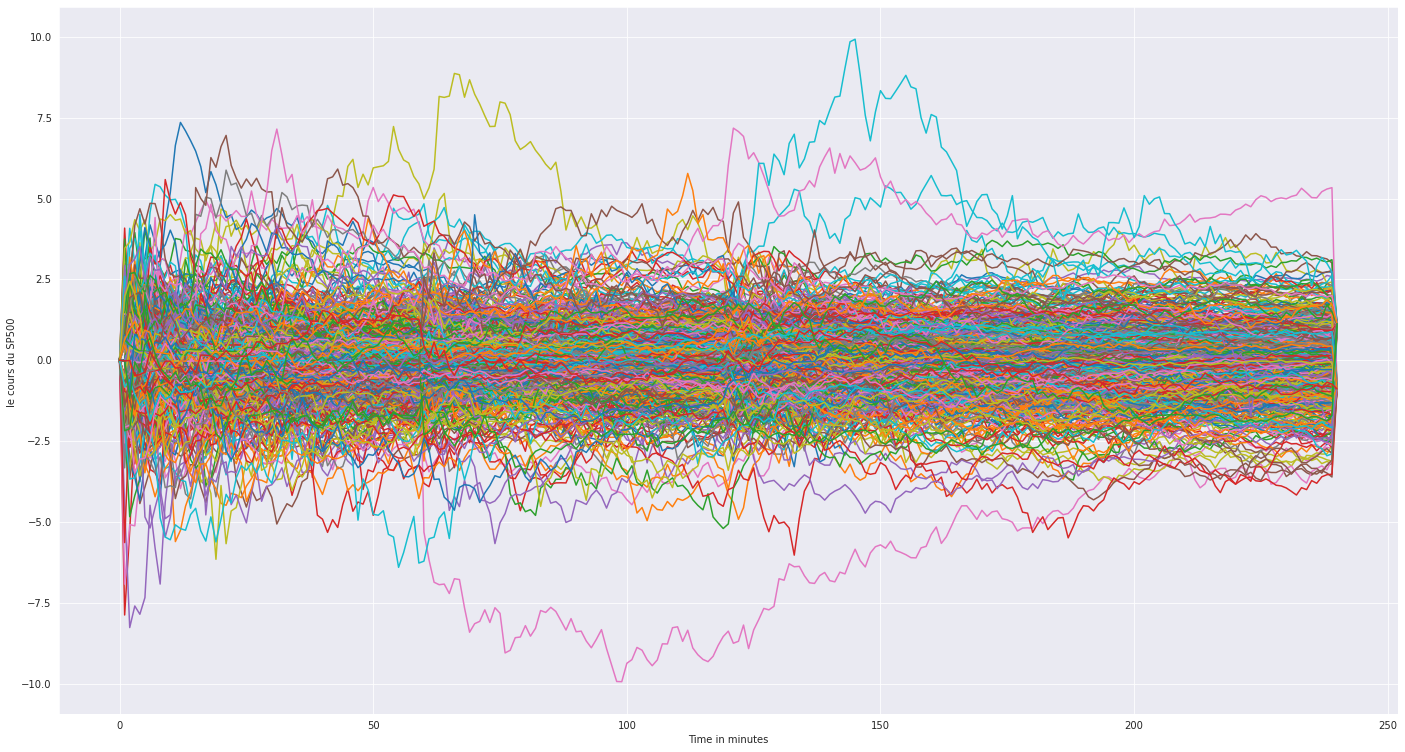

In [0]:
plot(ts_data);
xlabel("Time in minutes")
ylabel("le cours du SP500 ")

In [0]:
ts_data.shape

(1, 241, 914)

In [0]:
def windowed_dataset2(series):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(241).prefetch(1)

In [0]:
windowed_dataset2(ts_data)

In [0]:
import tensorflow as tf

In [0]:
a = np.array([[1,2,3],[4,5,6],[7,8,9], [10,11,12]]); a.shape

(4, 3)

In [0]:
sd = windowed_dataset2(a); sd

<PrefetchDataset shapes: ((None, 2, 1), (None, 2, 1)), types: (tf.int64, tf.int64)>